# 6. Decision Trees and Ensemble Learning


This week, we'll talk about decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project

* Dataset: https://github.com/gastonstat/CreditScoring

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data cleaning and preparation

* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
# !wget $data

In [4]:
# !head CreditScoring.csv

In [5]:
df = pd.read_csv('CreditScoring.csv')

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [8]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [9]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [12]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [14]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [15]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [18]:
del df_train['status']
del df_val['status']
del df_test['status']

In [19]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## 6.3 Decision trees

* How a decision tree looks like
* Training a decision tree 
* Overfitting
* Controlling the size of a tree

In [20]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [21]:
xi = df_train.iloc[0].to_dict()

In [22]:
assess_risk(xi)

'ok'

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [24]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [25]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [28]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6501114044222711

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [30]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [31]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [32]:
print(export_text(dt, feature_names=dv.get_feature_names_out().tolist()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



## 6.4 Decision tree learning algorithm

* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [33]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [34]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [35]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [36]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


default    0.75
ok         0.25
Name: status, dtype: float64


In [37]:
from IPython.display import display

In [38]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



In [39]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [40]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [41]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [42]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

#####################


## 6.5 Decision trees parameter tuning

* selecting `max_depth`
* selecting `min_samples_leaf`

In [60]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
#     print('%4s -> %.3f' % (depth, auc))
    print(f'{str(depth): <4} -> $ {auc:.3f}')

1    -> $ 0.606
2    -> $ 0.669
3    -> $ 0.739
4    -> $ 0.761
5    -> $ 0.766
6    -> $ 0.760
10   -> $ 0.684
15   -> $ 0.662
20   -> $ 0.655
None -> $ 0.646


In [42]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [43]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [44]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.750
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<AxesSubplot: xlabel='None-max_depth', ylabel='min_samples_leaf'>

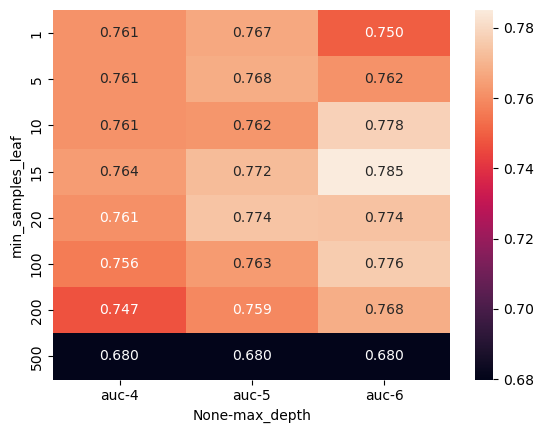

In [45]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [46]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [47]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1600.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1600.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

/home/st/mambaforge/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 6.6 Ensembles and random forest

* Board of experts
* Ensembling models 
* Random forest - ensembling decision trees
* Tuning random forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [50]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

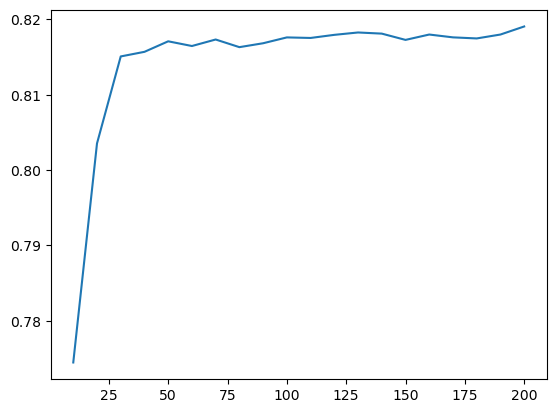

In [51]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [52]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [53]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

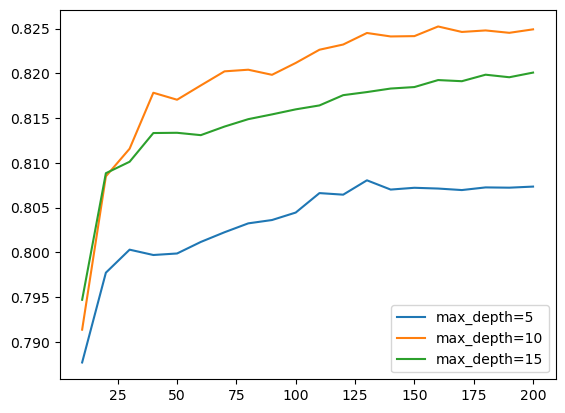

In [54]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend();

In [55]:
max_depth = 10

In [56]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [57]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

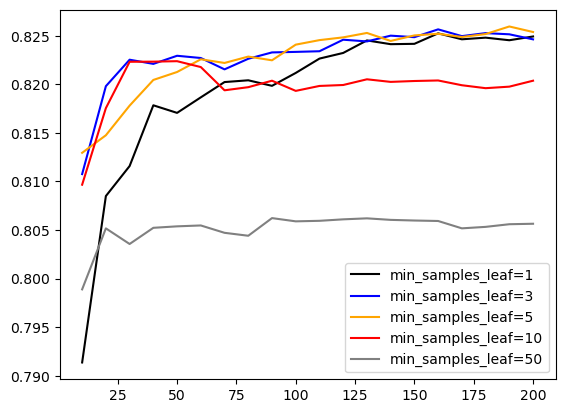

In [58]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%s' % s)

plt.legend();

In [59]:
min_samples_leaf = 3

In [60]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1)

Other useful parametes:

* `max_features`
* `bootstrap`

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 6.7 Gradient boosting and XGBoost

* Gradient boosting vs random forest
* Installing XGBoost
* Training the first model
* Performance monitoring
* Parsing xgboost's monitoring output

In [ ]:
# !pip install xgboost

In [61]:
import xgboost as xgb
xgb.__version__

'1.6.2'

In [63]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [64]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [65]:
y_pred = model.predict(dval)

In [66]:
roc_auc_score(y_val, y_pred)

0.8152745150274878

In [67]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [68]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [69]:
s = output.stdout

In [70]:
print(s[:200])

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	tr


In [71]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [72]:
df_score = parse_xgb_output(output)

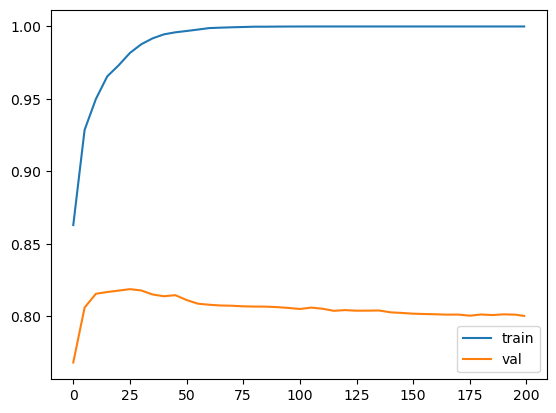

In [73]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

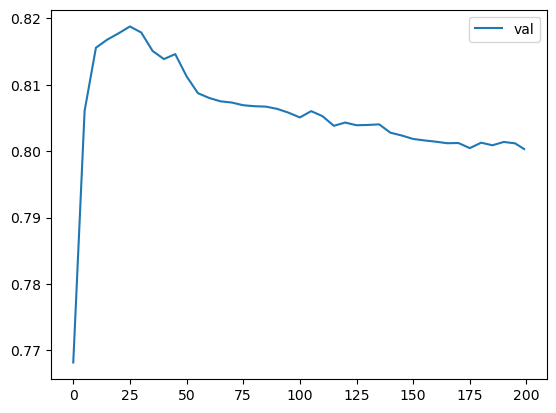

In [74]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## 6.8 XGBoost parameter tuning

Tuning the following parameters:

* `eta`
* `max_depth`
* `min_child_weight`


In [75]:
scores = {}

In [76]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [77]:
scores = {}

In [78]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [79]:
scores = {}

In [91]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [92]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [87]:
del scores['max_depth=10']

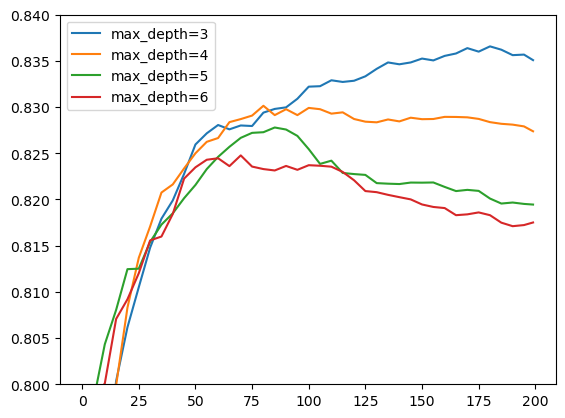

In [93]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

In [94]:
scores = {}

In [110]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [111]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

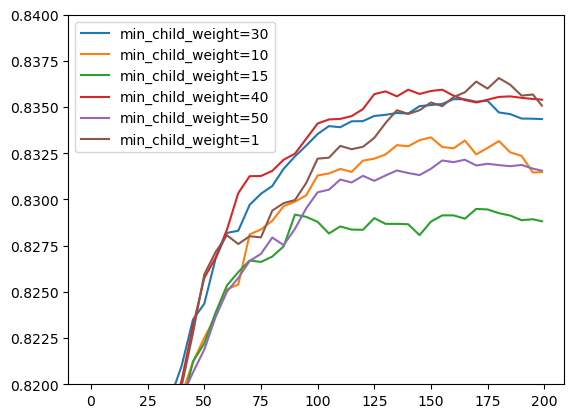

In [112]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

In [113]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

* `subsample` and `colsample_bytree`
* `lambda` and `alpha`

## 6.9 Selecting the final model

* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [114]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [115]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7850802838390931

In [116]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [117]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [118]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [119]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

In [120]:
df_full_train = df_full_train.reset_index(drop=True)

In [121]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [122]:
del df_full_train['status']

In [123]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [125]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out().tolist())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [126]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [127]:
y_pred = model.predict(dtest)

In [128]:
roc_auc_score(y_test, y_pred)

0.8322662626460096

## 6.10 Summary

* Decision trees learn if-then-else rules from data.
* Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
* Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
* Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting. 

## 6.11 Explore more

* For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
* For random forest, there are more parameters that we can tune. Check `max_features` and `bootstrap`.
* There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.
* XGBoost can deal with NAs - we don't have to do `fillna` for it. Check if not filling NA's help improve performance.
* Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for [random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (it's the same for plain decision trees) and for [xgboost](https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost)
* Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for XGBoost.